# Tiny ImageNet: View Predictions and Saliency

This notebook predicts the top-5 most likely labels for a random selection of images. The human labels, along with the top-5 model predictions, are displayed below each picture. Also, a "saliency map" is displayed next to each image. The saliency map highlights areas that were most important in making the top prediction. 

It is worth noting that a human labeler would have a difficult time correctly identifying many of these down-sampled images. The human labelers had the advantage of 4x higher resolution images to make their predictions (256x256 vs. 64x64 images). So, the model performance is quite impressive considering the low-resolution images.

The last cell may be re-run multiple times to explore a new selection of pictures.

Python Notebook by Patrick Coady: [Learning Artificial Intelligence](https://pat-coady.github.io/)

In [1]:
from train import *
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import random
import scipy.ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
class TrainConfig(object):
    """Training configuration"""
    dropout_keep_prob = 1.0
    model_name = 'vgg_16'  # choose model 
    model = staticmethod(globals()[model_name])
    config_name = 'baseline'  # choose training run

In [3]:
def predict(imgs, config):
    """Load most recent checkpoint, make predictions, compute saliency maps"""
    g = tf.Graph()
    with g.as_default():
        imgs_ph = tf.placeholder(dtype=tf.uint8, shape=(None, 56, 56, 3))
        logits = config.model(imgs_ph, config)
        top_pred = tf.reduce_max(logits, axis=1)
        top_5 = tf.nn.top_k(logits, k=5, sorted=True)
        # can't calculate gradient to integer, get float32 version of image:
        float_img = g.get_tensor_by_name('Cast:0')
        # calc gradient of top predicted class to image:
        grads = tf.gradients(top_pred, float_img)
        saver = tf.train.Saver()
        with tf.Session() as sess:
            path = 'checkpoints/' + config.model_name + '/' + config.config_name
            saver.restore(sess, tf.train.latest_checkpoint(path))
            feed_dict = {imgs_ph: imgs}
            top_5_np, grads_np = sess.run([top_5, grads], feed_dict=feed_dict)
      
    return top_5_np, grads_np

In [4]:
# get label integer -> text description dictionary
label_dict, class_description = build_label_dicts()
for i in range(len(class_description)):
    class_description[i] = class_description[i].split(',')[0]

INFO:tensorflow:Restoring parameters from checkpoints/vgg_16/baseline/model-42000


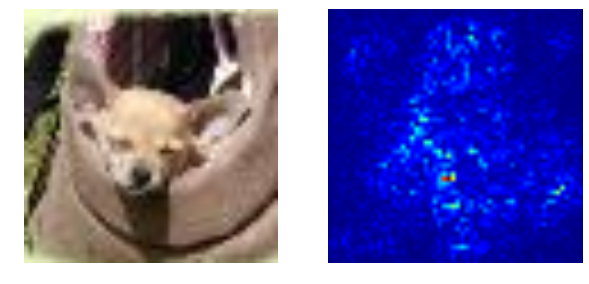

Actual label: Chihuahua
Top 5 predictions:
['Chihuahua', 'Labrador retriever', 'golden retriever', 'hog', 'German shepherd']




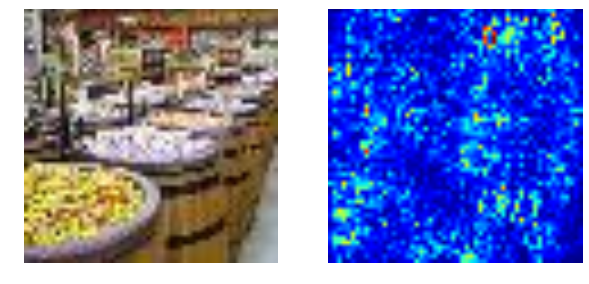

Actual label: confectionery
Top 5 predictions:
['confectionery', 'butcher shop', 'organ', 'chest', 'abacus']




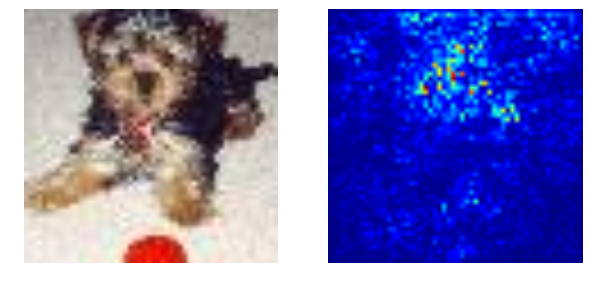

Actual label: Yorkshire terrier
Top 5 predictions:
['Yorkshire terrier', 'Chihuahua', 'standard poodle', 'Labrador retriever', 'teddy']




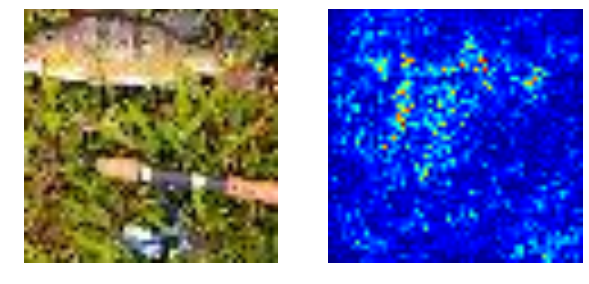

Actual label: reel
Top 5 predictions:
['confectionery', 'mushroom', 'reel', 'tractor', 'comic book']




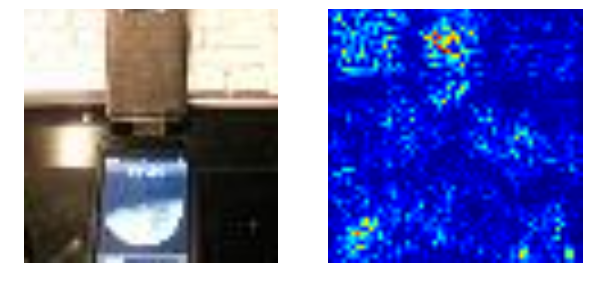

Actual label: iPod
Top 5 predictions:
['water jug', 'candle', 'barrel', 'pill bottle', 'bucket']




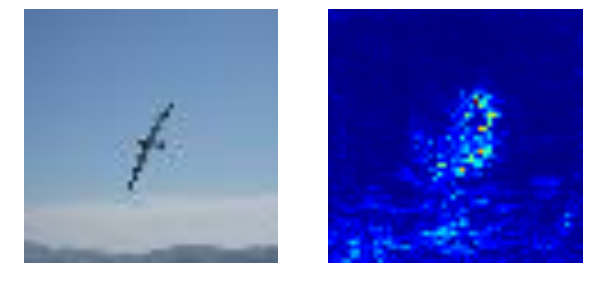

Actual label: albatross
Top 5 predictions:
['albatross', 'projectile', 'flagpole', 'pole', 'crane']




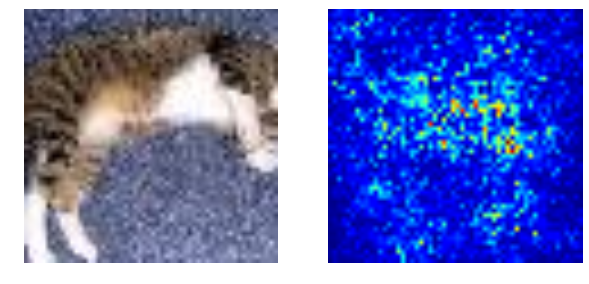

Actual label: Egyptian cat
Top 5 predictions:
['koala', 'Egyptian cat', 'tabby', 'sunglasses', 'Persian cat']




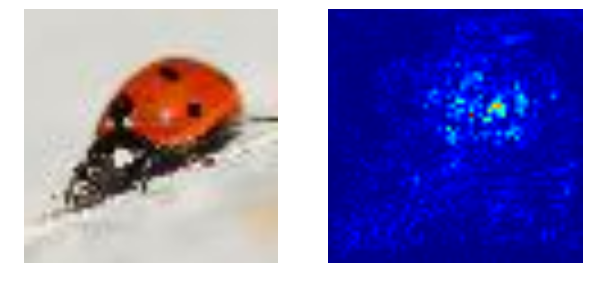

Actual label: ladybug
Top 5 predictions:
['ladybug', 'goldfish', 'pill bottle', 'snail', 'golden retriever']




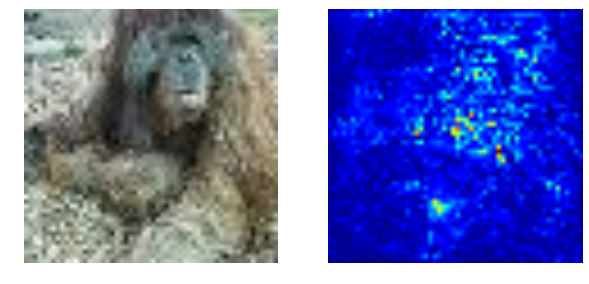

Actual label: orangutan
Top 5 predictions:
['orangutan', 'baboon', 'lion', 'chimpanzee', 'bighorn']




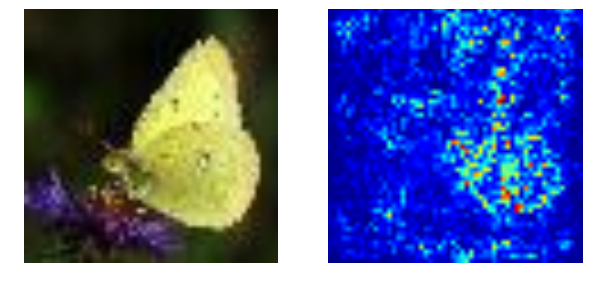

Actual label: sulphur butterfly
Top 5 predictions:
['sulphur butterfly', 'fly', 'monarch', 'bee', 'grasshopper']




In [6]:
N = 10  # number of validation examples to view
filenames_labels = load_filenames_labels('val')
pick_N = random.sample(filenames_labels, N)
imgs = np.zeros((N, 64, 64, 3), dtype=np.uint8)
labels = []
for i, filename_label in enumerate(pick_N):
    imgs[i, :, :, :] = scipy.ndimage.imread(filename_label[0], mode='RGB')
    labels.append(class_description[int(filename_label[1])])
imgs = imgs[:, 4:60, 4:60, :]  # take center crop of images
config = TrainConfig()
top_5, sal_imgs = predict(imgs, config)
top_5 = top_5[1]  # 2nd element of list are class predictions
sal_imgs = sal_imgs[0]  # 1st element of list are saliency maps
# root-sum-square RGB channels of generated saliency heat map
sal_imgs = np.sqrt(np.sum(np.square(sal_imgs), axis=3))

for idx, filename in enumerate(pick_N):
    plt.subplot(121)
    plt.imshow(imgs[idx, :, :, :])
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(sal_imgs[idx, :, :])
    plt.axis('off')
    plt.show()
    print('Actual label: ' + labels[idx])
    print('Top 5 predictions:')
    preds = map(lambda x: class_description[x], top_5[idx])
    print([x for x in preds])
    print('\n')